In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Importing data

In [2]:
df = pd.read_csv('customer_segmentation_data.csv', sep = ',', index_col = False)

## EDA

In [3]:
df.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [4]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [5]:
## Checking for missing values
df.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

In [6]:
df_seg = df.copy()

In [7]:
## Filling missing values
df_seg = df_seg.fillna(0)

In [8]:
df_seg.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [9]:
df_seg.dtypes

minutes_watched    float64
CLV                float64
region               int64
channel              int64
dtype: object

### Correlation

In [10]:
df_seg.corr()

,minutes_watched,CLV,region,channel
minutes_watched,1.000000,0.114153,0.040100,-0.003718
CLV,0.114153,1.000000,-0.273312,-0.026359
region,0.040100,-0.273312,1.000000,0.015098
channel,-0.003718,-0.026359,0.015098,1.000000


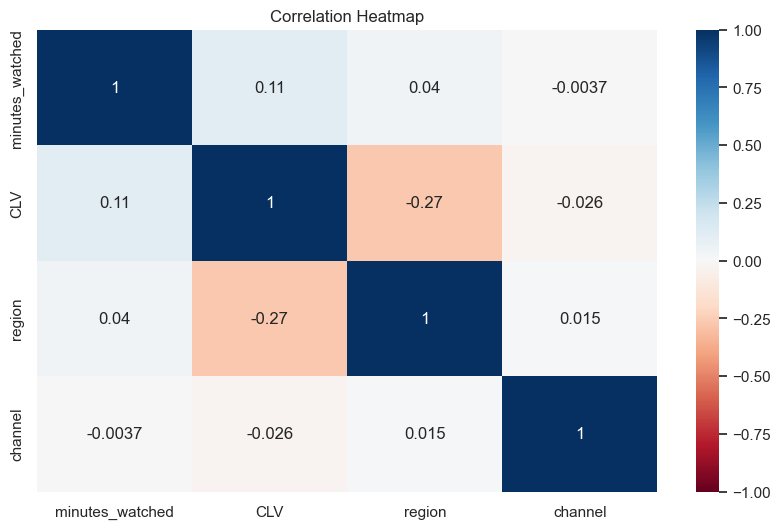

In [11]:
plt.figure(figsize = (10, 6))
s = sns.heatmap(df_seg.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels())
s.set_xticklabels(s.get_xticklabels())
plt.title('Correlation Heatmap', fontsize = 12)
plt.savefig('corr.png')
plt.show()

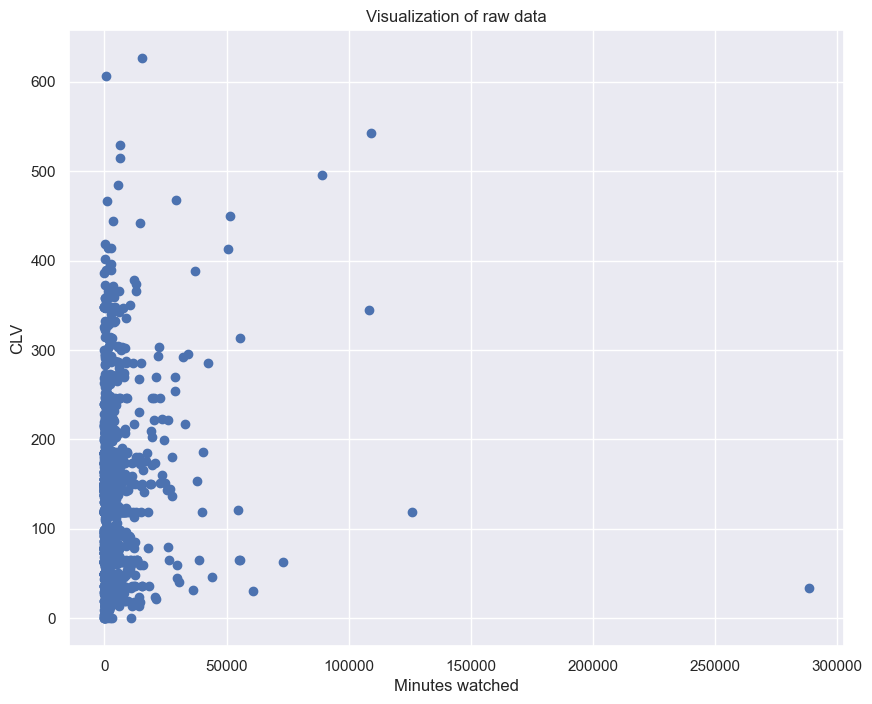

In [12]:
plt.figure(figsize = (10, 8))
plt.scatter(df_seg['minutes_watched'], df_seg['CLV'])
plt.xlabel('Minutes watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data', fontsize = 12)
plt.savefig("scatter.png")
plt.show()

## Creating dummy variables

In [13]:
# Channel dummies
segment_dummies = pd.get_dummies(df_seg['channel'], prefix = 'channel', prefix_sep = '_')
segment_dummies = segment_dummies.astype(int)
df_seg = pd.concat([df_seg, segment_dummies], axis = 1)

In [14]:
# Region dummies
segment_dummies_2 = pd.get_dummies(df_seg['region'] , prefix = 'country_region', prefix_sep = '_')
segment_dummies_2 = segment_dummies_2.astype(int)
df_seg = pd.concat([df_seg, segment_dummies_2], axis = 1)

In [15]:
# rename the columns after adding the dummie variables
df_seg = df_seg.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube',
                                                    'channel_4':'LinkedIn', 'channel_5':'Twitter', 'channel_6':'Instagram',
                                                    'channel_7':'Friend', 'channel_8':'Other', 'country_region_0':'Region_0',
                                                    'country_region_1':'Region_1','country_region_2':'Region_2'})

In [16]:
# drop the channel variable
df_seg = df_seg.drop(["channel"], axis = 1)

In [17]:
df_seg

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
0,3197.0,205.42,2,0,0,0,1,0,0,0,0,0,0,1
1,63.0,149.99,0,1,0,0,0,0,0,0,0,1,0,0
2,605.0,119.00,2,0,1,0,0,0,0,0,0,0,0,1
3,20.0,240.00,2,0,0,0,1,0,0,0,0,0,0,1
4,245.0,184.36,1,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,0,0,1,0,0,0,0,0,1,0,0
3830,28.0,79.00,0,0,1,0,0,0,0,0,0,1,0,0
3831,57.0,36.00,2,0,1,0,0,0,0,0,0,0,0,1
3832,44.0,36.00,2,1,0,0,0,0,0,0,0,0,0,1


In [18]:
df_seg.dtypes

minutes_watched    float64
CLV                float64
region               int64
Google               int32
Facebook             int32
YouTube              int32
LinkedIn             int32
Twitter              int32
Instagram            int32
Friend               int32
Other                int32
Region_0             int32
Region_1             int32
Region_2             int32
dtype: object

# Model

### Standardization

In [19]:
scaler = StandardScaler()
seg_std = scaler.fit_transform(df_seg)

### Hierarchical clustering

In [20]:
# Performing hierarchical clustering on the standardized data using the 'ward' method.
hier_clust = linkage(seg_std, method = 'ward')

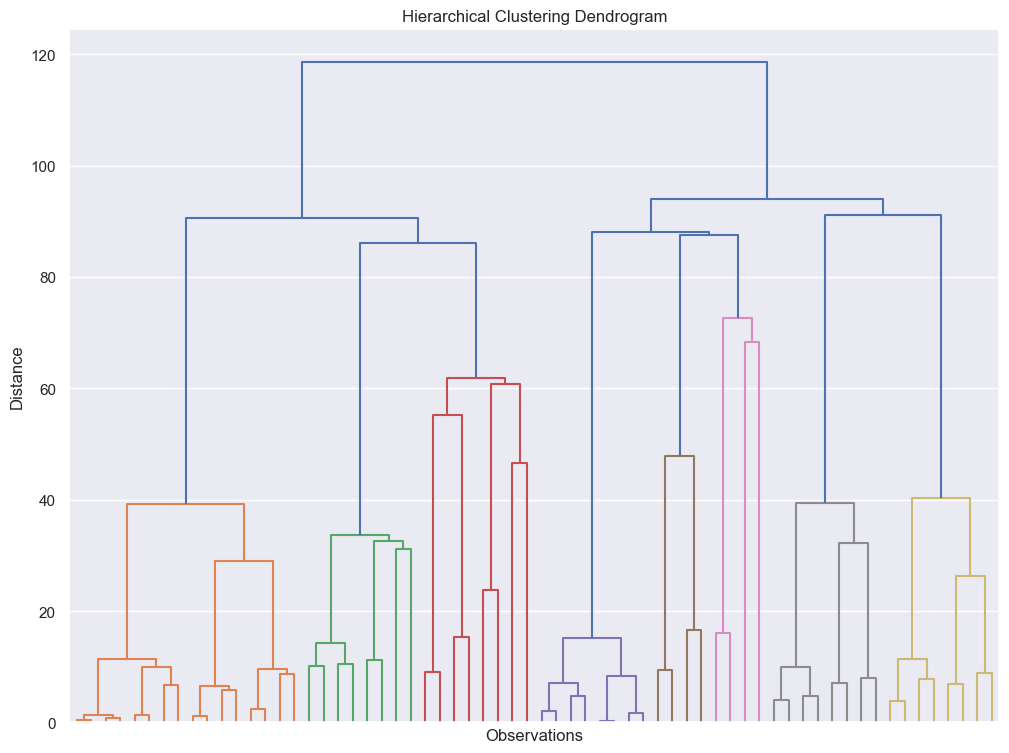

In [21]:
# Dendrogram plot
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
# Truncating the dendrogram to show only the last 5 merged clusters.
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

#### This clustering method suggest 8 clusters should be used, we can confirm it using Elbow method.

## K-means clustering

In [22]:
# Initializing an empty list to store the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers.
wcss = []

for i in range(1,11):
    # Using the 'k-means++' method to initialize the centroids which tends to speed up convergence.
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 30)
    kmeans.fit(seg_std)
    wcss.append(kmeans.inertia_)

C:\Users\him10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\him10\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\him10\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\him10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid

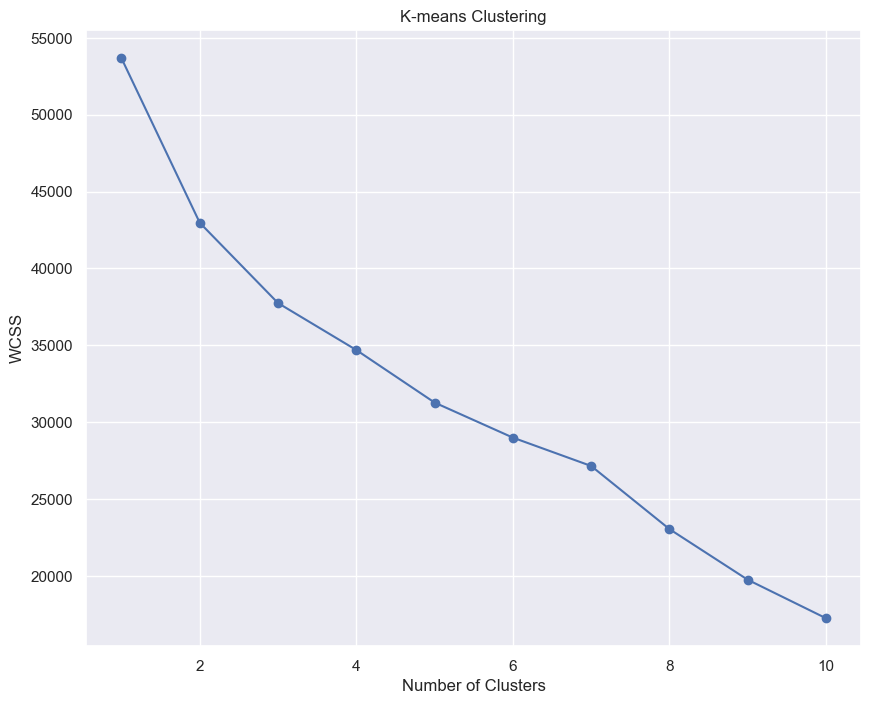

In [23]:
plt.figure(figsize = (10,8))

# Plotting the WCSS values against the number of clusters(Elbow Method). 
plt.plot(range(1, 11), wcss, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.savefig('line_chart.png')
plt.show()

#### The graph is smooth at point 8, so we can use n_clusters = 8

In [24]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 30)

In [25]:
kmeans.fit(seg_std)

C:\Users\him10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\him10\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


KMeans(random_state=30)

## Model Interpretation

In [26]:
df_seg_kmean = df_seg.copy()

In [27]:
df_seg_kmean['Segment'] = kmeans.labels_

In [28]:
df_seg_kmean

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,Segment
0,3197.0,205.42,2,0,0,0,1,0,0,0,0,0,0,1,1
1,63.0,149.99,0,1,0,0,0,0,0,0,0,1,0,0,0
2,605.0,119.00,2,0,1,0,0,0,0,0,0,0,0,1,3
3,20.0,240.00,2,0,0,0,1,0,0,0,0,0,0,1,1
4,245.0,184.36,1,0,0,0,1,0,0,0,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,0,0,1,0,0,0,0,0,1,0,0,0
3830,28.0,79.00,0,0,1,0,0,0,0,0,0,1,0,0,0
3831,57.0,36.00,2,0,1,0,0,0,0,0,0,0,0,1,3
3832,44.0,36.00,2,1,0,0,0,0,0,0,0,0,0,1,2


#### Analysing data segment wise

In [29]:
# Mean of each feature segment wise
df_seg_analysis = df_seg_kmean.groupby(['Segment']).mean()
df_seg_analysis

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
Segment,,,,,,,,,,,,,,
0,1535.688730,137.425528,0.000000,0.234347,0.078712,0.407871,0.169052,0.0,0.0,0.110018,0.0,1.000000,0.000000,0.000000
1,1801.265985,91.118312,2.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000
2,1834.219512,98.188110,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000
3,2572.781782,99.783283,2.000000,0.000000,0.187187,0.511512,0.000000,0.0,0.0,0.301301,0.0,0.000000,0.000000,1.000000
4,1299.332180,115.180277,1.186851,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.311419,0.190311,0.498270
5,1801.410468,161.314463,1.000000,0.223140,0.085399,0.349862,0.192837,0.0,0.0,0.148760,0.0,0.000000,1.000000,0.000000
6,2314.083333,123.189965,0.833333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.513889,0.138889,0.347222
7,985.327586,93.151552,1.603448,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.172414,0.051724,0.775862


In [30]:
# Proportion of observation for each segment
df_seg_analysis['N Obs'] = df_seg_kmean[['Segment','Region_0']].groupby(['Segment']).count()
df_seg_analysis['Prop Obs'] = df_seg_analysis['N Obs'] / df_seg_analysis['N Obs'].sum()
df_seg_analysis

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
0,1535.688730,137.425528,0.000000,0.234347,0.078712,0.407871,0.169052,0.0,0.0,0.110018,0.0,1.000000,0.000000,0.000000,1118,0.291601
1,1801.265985,91.118312,2.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,391,0.101982
2,1834.219512,98.188110,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,328,0.085550
3,2572.781782,99.783283,2.000000,0.000000,0.187187,0.511512,0.000000,0.0,0.0,0.301301,0.0,0.000000,0.000000,1.000000,999,0.260563
4,1299.332180,115.180277,1.186851,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.311419,0.190311,0.498270,289,0.075378
5,1801.410468,161.314463,1.000000,0.223140,0.085399,0.349862,0.192837,0.0,0.0,0.148760,0.0,0.000000,1.000000,0.000000,363,0.094679
6,2314.083333,123.189965,0.833333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.513889,0.138889,0.347222,288,0.075117
7,985.327586,93.151552,1.603448,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.172414,0.051724,0.775862,58,0.015128


In [31]:
df_seg_analysis = df_seg_analysis.round(2)

#### Assigning names to segment indices

In [32]:
df_seg_analysis.rename({0: 'US-CA-UK-AU Multi-Channel', 1: 'LinkedIn Networkers', 2: 'Google', 3: 'World Multi-Channel',
                                                        4: 'Instagram Followers', 5: 'West European Multi-Channel',
                                                        6: 'Other', 7: 'Twitter Devotees' }, inplace = True)

In [33]:
df_seg_analysis.rename(columns = {'Region_0': 'US-CA-UK-AU', 'Region_1': 'Western Europe',
                        'Region_2': 'World'}, inplace = True)

In [34]:
df_seg_analysis

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,US-CA-UK-AU,Western Europe,World,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
US-CA-UK-AU Multi-Channel,1535.69,137.43,0.00,0.23,0.08,0.41,0.17,0.0,0.0,0.11,0.0,1.00,0.00,0.00,1118,0.29
LinkedIn Networkers,1801.27,91.12,2.00,0.00,0.00,0.00,1.00,0.0,0.0,0.00,0.0,0.00,0.00,1.00,391,0.10
Google,1834.22,98.19,2.00,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,1.00,328,0.09
World Multi-Channel,2572.78,99.78,2.00,0.00,0.19,0.51,0.00,0.0,0.0,0.30,0.0,0.00,0.00,1.00,999,0.26
Instagram Followers,1299.33,115.18,1.19,0.00,0.00,0.00,0.00,0.0,1.0,0.00,0.0,0.31,0.19,0.50,289,0.08
West European Multi-Channel,1801.41,161.31,1.00,0.22,0.09,0.35,0.19,0.0,0.0,0.15,0.0,0.00,1.00,0.00,363,0.09
Other,2314.08,123.19,0.83,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.0,0.51,0.14,0.35,288,0.08
Twitter Devotees,985.33,93.15,1.60,0.00,0.00,0.00,0.00,1.0,0.0,0.00,0.0,0.17,0.05,0.78,58,0.02


In [35]:
#### Mapping the names
df_seg_kmean['Labels'] = df_seg_kmean['Segment'].map({0: 'US-CA-UK-AU Multi-Channel', 1: 'LinkedIn Networkers', 2: 'Google',
                                                      3: 'World Multi-Channel',4: 'Instagram Followers',
                                                      5: 'West European Multi-Channel', 6: 'Other', 7: 'Twitter Devotees' })

In [36]:
df_seg_kmean.head()

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,Segment,Labels
0,3197.0,205.42,2,0,0,0,1,0,0,0,0,0,0,1,1,LinkedIn Networkers
1,63.0,149.99,0,1,0,0,0,0,0,0,0,1,0,0,0,US-CA-UK-AU Multi-Channel
2,605.0,119.00,2,0,1,0,0,0,0,0,0,0,0,1,3,World Multi-Channel
3,20.0,240.00,2,0,0,0,1,0,0,0,0,0,0,1,1,LinkedIn Networkers
4,245.0,184.36,1,0,0,0,1,0,0,0,0,0,1,0,5,West European Multi-Channel


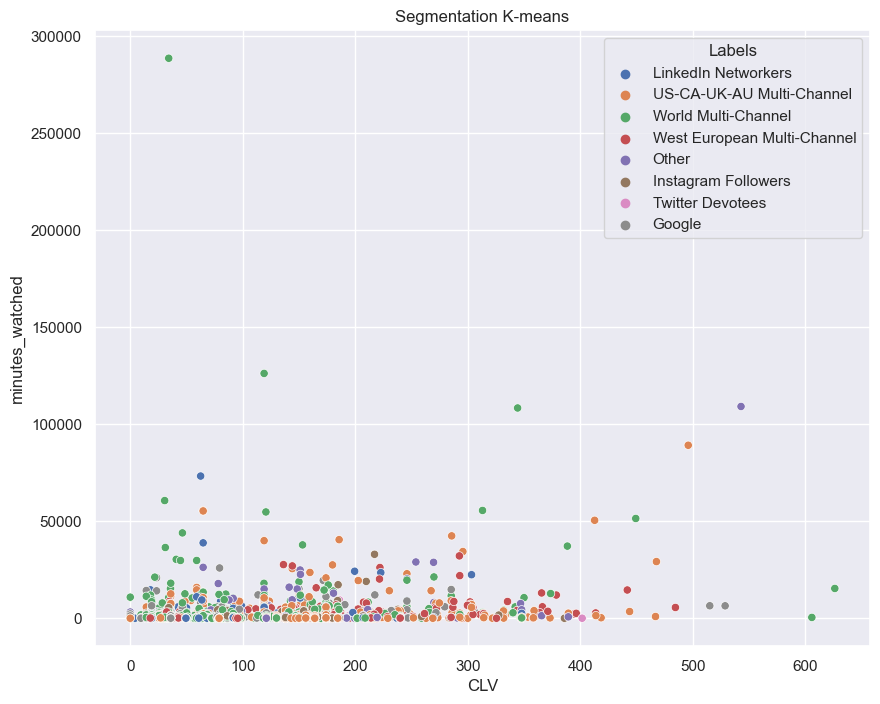

In [37]:
x_axis = df_seg_kmean['CLV']
y_axis = df_seg_kmean['minutes_watched']
plt.figure(figsize = (10, 8))
sns.scatterplot(x = df_seg_kmean['CLV'], y = df_seg_kmean['minutes_watched'], hue = df_seg_kmean['Labels'])
plt.title('Segmentation K-means')
plt.show()